## Imports

In [1]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from torch.nn.utils.rnn import pad_sequence

from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, r2_score
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import random

In [3]:
data_path = '/home/jupyter/SalaryPrediction/Data/'

train_path = data_path + 'train_clean_with_text.csv'
val_path = data_path + 'val_clean_with_text.csv'
test_path = data_path + 'test_clean_with_text.csv'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Fixing seeds

In [5]:
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed) #const hash for python
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Data reading

In [1]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

NameError: name 'pd' is not defined

In [7]:
df_train.head()

,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized
0,The Litigation team at this well regarded Comm...,london,full_time,permanent,Other,Legal Jobs,100000
1,Endoscopy Staff Nurse NHS London **** **** H...,thecity,full_time,permanent,ukstaffsearch,Other/General Jobs,29284
2,An experienced Operations Director is required...,letchworthgardencity,full_time,permanent,ukstaffsearch,Consultancy Jobs,97500
3,The Danny Sullivan Group is looking for a Site...,dudley,full_time,permanent,cvbrowser,Engineering Jobs,34320
4,A promising opportunity for an exceptional man...,kent,full_time,permanent,Other,Accounting & Finance Jobs,37500


## Data cleaning

#### Spliting dataset

In [8]:
X_train = df_train.drop('SalaryNormalized', axis=1)
y_train = df_train['SalaryNormalized']

X_val = df_val.drop('SalaryNormalized', axis=1)
y_val = df_val['SalaryNormalized']

X_test = df_test.drop('SalaryNormalized', axis=1)
y_test = df_test['SalaryNormalized']

In [9]:
X_train.shape

(172683, 6)

#### Log transformation

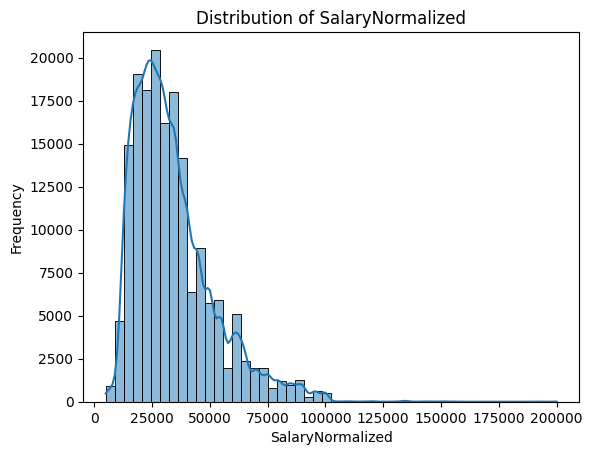

In [10]:
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribution of SalaryNormalized')
plt.xlabel('SalaryNormalized')
plt.ylabel('Frequency')
plt.show()

In [11]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

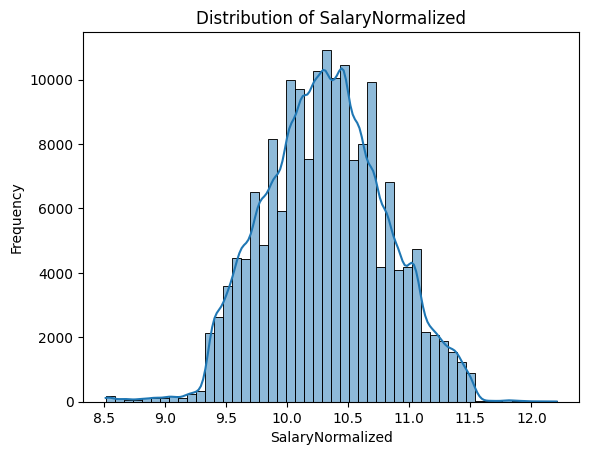

In [12]:
sns.histplot(y_train, bins=50, kde=True)
plt.title('Distribution of SalaryNormalized')
plt.xlabel('SalaryNormalized')
plt.ylabel('Frequency')
plt.show()

#### Tokenization

In [13]:
stop_words = set(stopwords.words("english"))

#'The white flower.'
def tokenize_description(text):
    text = text.translate(str.maketrans('', '', string.punctuation)) #'The white flower'
    tokens = word_tokenize(text) #['The', 'white', 'flower']
    filtered = [word.lower() for word in tokens if word.lower() not in stop_words] #['white', 'flower']
    return filtered

def build_vocab(token_lists, min_freq=5):
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    freq = {}

    for tokens in token_lists:
        for word in tokens:
            freq[word] = freq.get(word, 0) + 1
            if freq[word] == min_freq:
                word2idx[word] = len(word2idx)

    return word2idx #word2idx = {'<PAD>':0, '<UNK>':1, 'white':2, 'flower':3}


def tokens_to_indices(tokens, word2idx):
    return [word2idx.get(word, word2idx['<UNK>']) for word in tokens]
#tokens=['white', 'flower', 'dog']
#word2idx = {'<PAD>':0, '<UNK>':1, 'white':2, 'flower':3}
#output = [2, 3, 1]

In [14]:
X_train['Token_Description'] = X_train['FullDescription'].apply(tokenize_description)
X_val['Token_Description'] = X_val['FullDescription'].apply(tokenize_description)
X_test['Token_Description'] = X_test['FullDescription'].apply(tokenize_description)

word2idx = build_vocab(X_train['Token_Description'])

train_seqs = [torch.tensor(tokens_to_indices(t, word2idx)) for t in X_train['Token_Description']]
val_seqs = [torch.tensor(tokens_to_indices(t, word2idx)) for t in X_val['Token_Description']]
test_seqs = [torch.tensor(tokens_to_indices(t, word2idx)) for t in X_test['Token_Description']]

#Before: [[2,1], [5], [2, 3, 4]]
train_seqs = pad_sequence(train_seqs, batch_first=True)
val_seqs = pad_sequence(val_seqs, batch_first=True)
test_seqs = pad_sequence(test_seqs, batch_first=True)
#After: [[2, 1, 0], [5, 0, 0], [2, 3, 4]]

vocab_size = len(word2idx)

In [ ]:
def tokenize_description_char(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return list(text.replace(" ", ""))

def build_char_vocab(token_lists, min_freq=1):
    char2idx = {'<PAD>': 0, '<UNK>': 1}
    freq = {}

    for tokens in token_lists:
        for char in tokens:
            freq[char] = freq.get(char, 0) + 1
            if freq[char] == min_freq:
                char2idx[char] = len(char2idx)

    return char2idx

def chars_to_indices(tokens, char2idx):
    return [char2idx.get(char, char2idx['<UNK>']) for char in tokens]

In [ ]:
X_train['Token_Description'] = X_train['FullDescription'].apply(tokenize_description_char)
X_val['Token_Description'] = X_val['FullDescription'].apply(tokenize_description_char)
X_test['Token_Description'] = X_test['FullDescription'].apply(tokenize_description_char)

char2idx = build_char_vocab(X_train['Token_Description'])

train_seqs = [torch.tensor(chars_to_indices(t, char2idx)) for t in X_train['Token_Description']]
val_seqs = [torch.tensor(chars_to_indices(t, char2idx)) for t in X_val['Token_Description']]
test_seqs = [torch.tensor(chars_to_indices(t, char2idx)) for t in X_test['Token_Description']]

train_seqs = pad_sequence(train_seqs, batch_first=True).to(device)
val_seqs = pad_sequence(val_seqs, batch_first=True).to(device)
test_seqs = pad_sequence(test_seqs, batch_first=True).to(device)

vocab_size = len(char2idx)

#### Label encoding

In [15]:
encoders = {}

X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()
X_test_encoded = X_test.copy()

for col in X_train.columns:
    if col != 'FullDescription' and col != 'Token_Description':  
        
        X_train_encoded[col] = le.fit_transform(X_train[col])
        X_val_encoded[col] = le.transform(X_val[col])
        X_test_encoded[col] = le.transform(X_test[col])
        
        encoders[col] = le


In [16]:
print(X_train.shape, X_val.shape, X_test.shape)

(172683, 7) (35369, 7) (36716, 7)


#### Embedding

In [18]:
embedding_sizes = []

for col in X_train_encoded.columns:
    if col == "Token_Description" or col == "FullDescription":
        continue
    num_categories = len(encoders[col].classes_) #num of unique values
    emb_dim = min(5, (num_categories + 1) // 4)
    embedding_sizes.append((num_categories, emb_dim))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sbert = SentenceTransformer('all-MiniLM-L6-v2', device=device)

with torch.no_grad():
    X_train_text_embeddings = sbert.encode(X_train['FullDescription'].tolist(), convert_to_tensor=True, device=device, show_progress_bar=True)
    X_val_text_embeddings = sbert.encode(X_val['FullDescription'].tolist(), convert_to_tensor=True, device=device, show_progress_bar=True)
    X_test_text_embeddings = sbert.encode(X_test['FullDescription'].tolist(), convert_to_tensor=True, device=device, show_progress_bar=True)

## Architecture

In [41]:
class SalaryDataset(Dataset):
    def __init__(self, X, y, char2idx):
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
        self.cat_data = torch.tensor(X.drop(columns=["Token_Description"]).values, dtype=torch.long)
        self.text_data = X["Token_Description"].tolist()
        self.char2idx = char2idx

    def __len__(self):
        return len(self.cat_data)

    def __getitem__(self, idx):
        text_indices = tokens_to_indices(self.text_data[idx], self.char2idx)
        return self.cat_data[idx], torch.tensor(text_indices, dtype=torch.long), self.y[idx]

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

class SalaryModel(nn.Module):
    def __init__(self, embedding_sizes, sentence_model_name='all-MiniLM-L6-v2', freeze_sentence_model=True):
        super().__init__()

        self.sentence_model = SentenceTransformer(sentence_model_name)

        if freeze_sentence_model:
            for param in self.sentence_model.parameters():
                param.requires_grad = False 

        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories, emb_dim in embedding_sizes
        ])
        cat_emb_dim = sum([emb_dim for _, emb_dim in embedding_sizes])

    
        total_input_dim = cat_emb_dim + text_emb_dim

        self.fc1 = nn.Linear(total_input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.2)

        self.fc3 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(0.1)

        self.fc_final = nn.Linear(16, 1)

    def forward(self, cat_input, text_input):
        embedded_cat = [emb(cat_input[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_out = torch.cat(embedded_cat, dim=1)


        text_input_list = [str(sentence) for sentence in text_input] 

        text_emb = self.sentence_model.encode(text_input_list, convert_to_tensor=True)

        x = torch.cat([cat_out, text_emb], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc_final(x)

        return x


## Training the model

In [43]:
#__get_item__: (cat_tensor, text_tensor, label)
#batch = [(tensor([1, 2]), tensor([3, 4, 5]), tensor([50000.])),
#         (tensor([0, 1]), tensor([7, 8]), tensor([60000.]))]


def collate_fn(batch):
    cat_feats, text_feats, labels = zip(*batch) #cat_feats = (tensor([1, 2]), tensor([0, 1]))
                                                #text_feats = (tensor([3, 4, 5]), tensor([7, 8]))
                                                #labels = (tensor([50000.]), tensor([60000.]))

    cat_feats = torch.stack(cat_feats) #cat_feats = (tensor([1,2], [0,1]))
    text_feats = pad_sequence(text_feats, batch_first=True, padding_value=0) #text_feats =(tensor([3,4,5], [7,8,0]))
    labels = torch.stack(labels) #labels = tensor([50000.], [60000.])

    return cat_feats, text_feats, labels

In [52]:
train_dataset = SalaryDataset(X_train_encoded, y_train, word2idx)
val_dataset = SalaryDataset(X_val_encoded, y_val, word2idx)
test_dataset = SalaryDataset(X_test_encoded, y_test, word2idx)

g = torch.Generator()
g.manual_seed(42)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=g, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, generator=g, collate_fn=collate_fn)

In [53]:
set_seed(42)

model = SalaryModel(
    embedding_sizes=embedding_sizes,
    sentence_model_name='all-MiniLM-L6-v2',
    freeze_sentence_model=True  
)

model = model.to(device)

loss_fn = torch.nn.SmoothL1Loss()

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_trainable_params(model)}")


Number of trainable parameters: 38509


In [54]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    num_batches = 0
    batch_losses = []

    for i, (cat_inputs, text_inputs, labels) in enumerate(train_loader):
        cat_inputs = cat_inputs.to(device)
        text_inputs = text_inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(cat_inputs, text_inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if i % 500 == 499:
            last_loss = running_loss / 500
            batch_losses.append(last_loss)
            print(f'  batch {i+1} loss: {last_loss:.4f}')
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0

    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    return last_loss, batch_losses

## Evaluation the model

In [47]:
def changing_to_original_metric(y_pred, y_true):
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")
    return y_pred, y_true

In [55]:
patience = 5
best_vloss = float('inf')
epochs_without_improvement = 0
model_save_path = 'best_model.pth'

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

epoch_number = 0
EPOCHS = 100

train_losses = []
val_losses = []
train_batch_losses = []
val_batch_losses = []


for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    model.train(True)
    avg_train_loss, batch_train_losses = train_one_epoch(epoch_number, writer)
    train_losses.append(avg_train_loss)
    train_batch_losses.extend(batch_train_losses)

    model.eval()
    running_vloss = 0.0
    r_vloss = 0.0
    batch_val_losses = []
    all_val_outputs = []
    all_val_labels = []

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            cat_inputs, text_inputs, vlabels = vdata

            cat_inputs = cat_inputs.to(device)
            text_inputs = text_inputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = model(cat_inputs, text_inputs)
            vloss = loss_fn(voutputs, vlabels)

            loss_value = vloss.item()
            running_vloss += loss_value
            r_vloss += loss_value
            if i % 500 == 499:
                last_loss = r_vloss / 500
                batch_val_losses.append(last_loss)
                r_vloss = 0.0

            all_val_outputs.extend(voutputs.cpu().numpy())
            all_val_labels.extend(vlabels.cpu().numpy())

    avg_vloss = running_vloss / (i + 1)
    val_losses.append(avg_vloss)
    val_batch_losses.extend(batch_val_losses)
    scheduler.step(avg_vloss)


    mse_val = mean_squared_error(all_val_labels, all_val_outputs)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(all_val_labels, all_val_outputs)

    print(f'LOSS train: {avg_train_loss:.4f}, valid: {avg_vloss:.4f}')
    print("--------------------------------")
    print(f"MSE: {mse_val:.4f}")
    print(f"RMSE: {rmse_val:.4f}")
    print(f"R²: {r2_val:.4f}")
    print("--------------------------------")
    print("Original scale")
    all_val_outputs_original, all_val_labels_original = changing_to_original_metric(all_val_outputs, all_val_labels)
    mse_val_original = mean_squared_error(all_val_labels_original, all_val_outputs_original)
    rmse_val_original = np.sqrt(mse_val_original)
    r2_val_original = r2_score(all_val_labels_original, all_val_outputs_original)
    print("\n")

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_train_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), model_save_path)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch_number + 1}')
        break

    epoch_number += 1


EPOCH 1:


KeyboardInterrupt: 

### Improvements

LOSS train: 0.0367, valid: 0.0395
MSE: 0.0796
RMSE: 0.2822
R²: 0.6695
Original scale
MSE: 122744712.0000
RMSE: 11079.0213
R²: 0.6059

Changing to LayerNorm:

LOSS train: 0.0230, valid: 0.0297
MSE: 0.0600
RMSE: 0.2450
R²: 0.7509
Original scale
MSE: 91618752.0000
RMSE: 9571.7685
R²: 0.7058

Adding convolutional layer:

LOSS train: 0.0309, valid: 0.0344
MSE: 0.0694
RMSE: 0.2635
R²: 0.7118
Original scale
MSE: 106721568.0000
RMSE: 10330.6131
R²: 0.6574

Changing to BatchNorm:

LOSS train: 0.0308, valid: 0.0337
MSE: 0.0678
RMSE: 0.2604
R²: 0.7184
Original scale
MSE: 104906728.0000
RMSE: 10242.3985
R²: 0.6632

4 fc layers from size 16:

LOSS train: 0.0307, valid: 0.0320
MSE: 0.0647
RMSE: 0.2543
R²: 0.7315
Original scale
MSE: 99451536.0000
RMSE: 9972.5391
R²: 0.6807

Start size: 32, Dropout 0.3, 0.2, 0.1

LOSS train: 0.0356, valid: 0.0323
MSE: 0.0651
RMSE: 0.2552
R²: 0.7295
Original scale
MSE: 98806824.0000
RMSE: 9940.1622
R²: 0.6828

With residual blocks

Start size: 64, maxpool, 2 conv layers

LOSS train: 0.0296, valid: 0.0344
MSE: 0.0695
RMSE: 0.2636
R²: 0.7116
Original scale
MSE: 106139200.0000
RMSE: 10302.3881
R²: 0.6592

Start size: 64, maxpool, 1 conv layer

LOSS train: 0.0282, valid: 0.0343
MSE: 0.0692
RMSE: 0.2631
R²: 0.7125
Original scale
MSE: 103569048.0000
RMSE: 10176.8879
R²: 0.6675

Start size: 64, avgpool, 2 conv layer

LOSS train: 0.0392, valid: 0.0342
MSE: 0.0690
RMSE: 0.2627
R²: 0.7135
Original scale
MSE: 106410232.0000
RMSE: 10315.5335
R²: 0.6583

Start size: 128, maxpool, 2 conv layers

LOSS train: 0.0394, valid: 0.0352
MSE: 0.0709
RMSE: 0.2663
R²: 0.7055
Original scale
MSE: 107717048.0000
RMSE: 10378.6824
R²: 0.6542

Dropout 0.1, 0.1, 0.1

LOSS train: 0.0256, valid: 0.0337
MSE: 0.0680
RMSE: 0.2608
R²: 0.7177
Original scale
MSE: 103173320.0000
RMSE: 10157.4268
R²: 0.6687

5 fc layers:

LOSS train: 0.0236, valid: 0.0344
MSE: 0.0694
RMSE: 0.2635
R²: 0.7118
Original scale
MSE: 107072096.0000
RMSE: 10347.5647
R²: 0.6562

pre fullactivation, Without dropout:

LOSS train: 0.0274, valid: 0.0344
MSE: 0.0694
RMSE: 0.2635
R²: 0.7117
Original scale
MSE: 106051376.0000
RMSE: 10298.1249
R²: 0.6595

LOSS train: 0.0250, valid: 0.0336
MSE: 0.0678
RMSE: 0.2604
R²: 0.7186
Original scale
MSE: 102795160.0000
RMSE: 10138.7948
R²: 0.6700

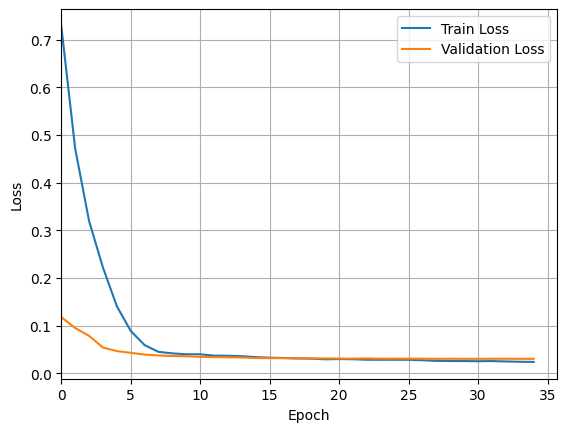

In [36]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0)
plt.legend()
plt.grid(True)
plt.show()


## Evaluation on the test set

In [37]:
model = SalaryModel(embedding_sizes, vocab_size=vocab_size, text_emb_dim=5)
model.load_state_dict(torch.load(model_save_path))
model.eval()

SalaryModel(
  (embeddings): ModuleList(
    (0): Embedding(1000, 5)
    (1-2): 2 x Embedding(3, 1)
    (3): Embedding(1001, 5)
    (4): Embedding(29, 5)
  )
  (text_embedding): Embedding(47112, 5, padding_idx=0)
  (fc1): Linear(in_features=22, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc_final): Linear(in_features=16, out_features=1, bias=True)
)

In [38]:
running_test_loss = 0.0


all_outputs = []
all_labels = []

with torch.no_grad():
    for i, (cat_inputs, text_inputs, test_labels) in enumerate(test_loader):
        test_outputs = model(cat_inputs, text_inputs)
        test_loss = loss_fn(test_outputs, test_labels)
        running_test_loss += test_loss.item()

        all_outputs.extend(test_outputs.numpy())
        all_labels.extend(test_labels.numpy())

avg_test_loss = running_test_loss / (i + 1)
print(f"Test Loss: {avg_test_loss:.4f}")

mse = mean_squared_error(all_labels, all_outputs)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_outputs)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Test Loss: 0.0303
MSE: 0.0615
RMSE: 0.2479
R²: 0.7454


In [39]:
all_outputs, all_labels = changing_to_original_metric(all_outputs, all_labels)

MSE: 96359712.0000
RMSE: 9816.2983
R²: 0.6912
